In [100]:
# Imports
import gurobipy as gp
import pulp as pl
import mosek as ms

import pandas as pd
import numpy as np
from pathlib import Path
import xml.etree.ElementTree as ET
from glob import glob
import os
import re
import csv
import shutil
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import masserstein
from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

In [2]:
# Create an environment with your WLS license
params = {
"WLSACCESSID": '',
"WLSSECRET": '',
"LICENSEID": ,
}
env = gp.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659106
Academic license 2659106 - for non-commercial use only - registered to a.___@student.uw.edu.pl


In [3]:
pl.listSolvers(onlyAvailable=True)

['GUROBI', 'MOSEK', 'PULP_CBC_CMD']

In [10]:
# Set up Gurobi as a solver
if 'GUROBI' in pl.listSolvers(onlyAvailable=True):
    solver = pl.GUROBI(env=env, msg=False)
else:
    solver = pl.apis.LpSolverDefault
print(solver)

In [2]:
solver = pl.MOSEK()
print(solver)

## Process xml files from HMDB

In [22]:
## Function that read xml file and save informations about peaks in csv file

def extract_1D_spectra(folder_path: str, nucleus: str):

    f_path = Path(folder_path)
    out_path = 'C:\\Users\\Anastazja\\HMDB\\csv5'

    if not os.path.exists(out_path):
      os.makedirs(out_path)

    for filename in os.listdir(f_path):
      #check if it is 1D
      template = 'nmr_one_d'
      if re.search(template, filename):

        #read xml file
        file = os.path.join(f_path, filename)
        tree = ET.parse(file)
        root = tree.getroot()

        nucls = root.find('nucleus')
        if nucls is None or nucls.text != nucleus: continue

        # parameters for filename
        HMDB_ID = root.find('.//database-id').text
        Spectrum_ID = root.find('id').text

        pred_exp = root.find('.//predicted')
        if pred_exp is not None and pred_exp.attrib.get('nil') != 'true':
          pred_exp = 'predicted'
        else:
          pred_exp = 'experimental'

        frequency = root.find('frequency')
        if frequency is not None and frequency.text is not None:
            frequency = re.sub(r"[a-zA-Z\s]", "", frequency.text).strip()
        else:
            frequency = 'unknown'

        out_csv_path = f'{out_path}\\{HMDB_ID}_1D_{Spectrum_ID}_{pred_exp}_{nucleus}_{frequency}.csv'

        # get the informations about all peaks in the spectrum
        # save them in csv file
        peaks = root.findall('.//nmr-one-d-peak')
        with open(out_csv_path, 'w', newline='') as csvfile:
          writer = csv.writer(csvfile)
          writer.writerow(['chemical_shift', 'peak_position_ppm', 'intensity'])

          for peak in peaks:
            chemical_shift = peak.find('chemical-shift').text
            peak_position_ppm = peak.find('peak-position-ppm').text
            intensity = peak.find('intensity').text

            writer.writerow([chemical_shift, peak_position_ppm, intensity])


  extract_1D_spectra("C:\\Users\\Anastazja\\HMDB\\hmdb_nmr_spectra_5", '1H')

In [42]:
### Ex. 1.4 Function to preprocess csv files, group same peaks and sum intensities

def preprocess_1D_spectra(filename: str, out_folder='Preprocessed', sig=None):

  df = pd.read_csv(f'C:\\Users\\Anastazja\\HMDB\\csv5\\{filename}')

  df['peak_position_ppm'] = df['peak_position_ppm'].astype(float)
  df['intensity'] = df['intensity'].astype(float)

  if sig!=None:
    df['peak_position_ppm'] = df['peak_position_ppm'].round(decimals=sig)

  grouped_df = df.groupby(['chemical_shift','peak_position_ppm'])['intensity'].sum().reset_index()

  if not os.path.exists(f'C:\\Users\\Anastazja\\HMDB\\{out_folder}'):
    # If it doesn't exist, create it
    os.makedirs(f'C:\\Users\\Anastazja\\HMDB\\{out_folder}')
  #pd.set_option('display.float_format', '{:.10f}'.format)

  grouped_df.to_csv(f'C:\\Users\\Anastazja\\HMDB\\{out_folder}\\{filename}_processed.csv', index=False)


In [43]:
f_path = 'C:\\Users\\Anastazja\\HMDB\\csv5'
for filename in os.listdir(f_path):
    preprocess_1D_spectra(filename)

In [63]:
## extract processed files for selected metabolites

#selected_metabolites = 'C:\\Users\\Anastazja\\HMDB\\Data_urine\\selected_metabolites.csv'
selected_metabolites2 = 'C:\\Users\\Anastazja\\HMDB\\selected_metabolites2.xlsx'
folder_path = 'C:\\Users\\Anastazja\\HMDB\\Preprocessed'
output_folder = 'C:\\Users\\Anastazja\\HMDB\\selected_met_spectra2'

#df = pd.read_csv(selected_metabolites)
df = pd.read_excel(selected_metabolites2)
hmdb_ids = df['HMDB.ca ID'].astype(str).tolist()

os.makedirs(output_folder, exist_ok=True)

for file in os.listdir(folder_path):
    for id in hmdb_ids:
        if id in file:
            source = f'{folder_path}\\{file}'
            target = f'{output_folder}\\{file}'
            shutil.copy2(source, target)  # save the metadata


In [71]:
## analyze csv files of specific metabolite in order to choose the best spectrum

folder_path = 'C:\\Users\\Anastazja\\HMDB\\selected_met_spectra2'
substring = "HMDB0001548"


for filename in os.listdir(folder_path):
    if substring in filename and 'experimental' in filename:
        file_path = f'{folder_path}\\{filename}'
        print(f"\n=== {filename} ===")

        df = pd.read_csv(file_path)
        print(df)


=== HMDB0001548_1D_5252_experimental_1H_500.csv_processed.csv ===
    chemical_shift  peak_position_ppm   intensity
0             3.81               3.81    7.389750
1             3.84               3.84   95.808502
2             3.85               3.85  100.000000
3             3.86               3.86   76.261422
4             3.87               3.87   81.128327
5             3.92               3.92   53.178387
6             3.93               3.93   84.505364
7             3.94               3.94   30.413190
8             4.05               4.05   85.399285
9             4.06               4.06   68.732618
10            4.07               4.07  130.095352
11            4.15               4.15    7.270560
12            4.18               4.18   61.402463
13            4.20               4.20  100.715137
14            4.21               4.21  130.770759
15            4.23               4.23    8.085022
16            4.29               4.29   49.642431
17            4.30               

In [3]:
### read chosen files of selected metabolites

df = pd.read_excel('C:\\Users\\Anastazja\\HMDB\\metabolites_decisions.xlsm')

# Edit Data Frame, save only needed rows
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.iloc[:, 0:4]
df = df.iloc[:-2]

chosen_files = df['chosen_file'].tolist()

In [4]:
print(len(chosen_files))

35


In [5]:
folder_path = 'C:\\Users\\Anastazja\\HMDB\\selected_met_spectra'

# list of paths to selected metabolites' csv files
chosen_paths = []

for file in chosen_files:
    path = f'{folder_path}\\{file}'
    chosen_paths.append(path)

metabolites_names = df['name'].tolist()

In [6]:
print(len(metabolites_names))

35


In [7]:
### create NMRSpectra objects of selected metabolites spectra
spectra1 = []
for name, path in zip(metabolites_names, chosen_paths):
    df = pd.read_csv(path)
    conf1 = df['peak_position_ppm'].tolist()
    conf2 = df['intensity'].tolist()

    spectrum = NMRSpectrum(confs=list(zip(conf1, conf2)),
                           label=name)

    spectrum.trim_negative_intensities()
    spectrum.normalize()
    spectra1.append(spectrum)

In [8]:
print(len(spectra1))

35


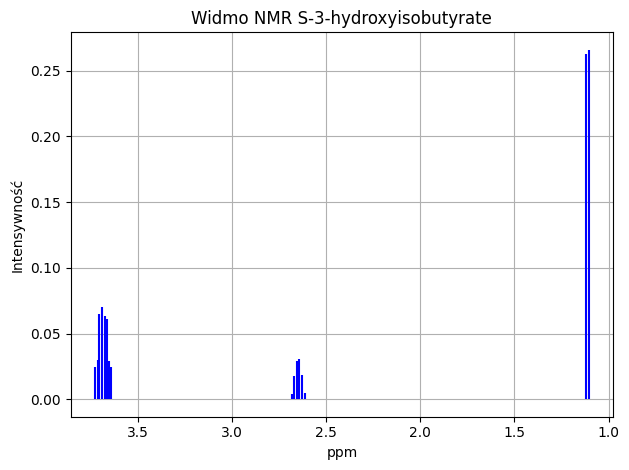

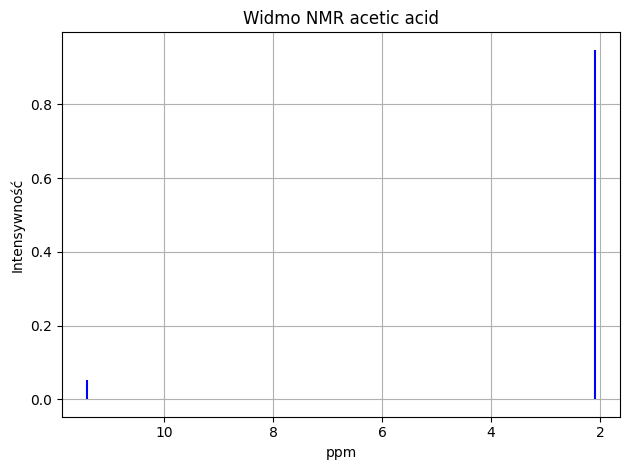

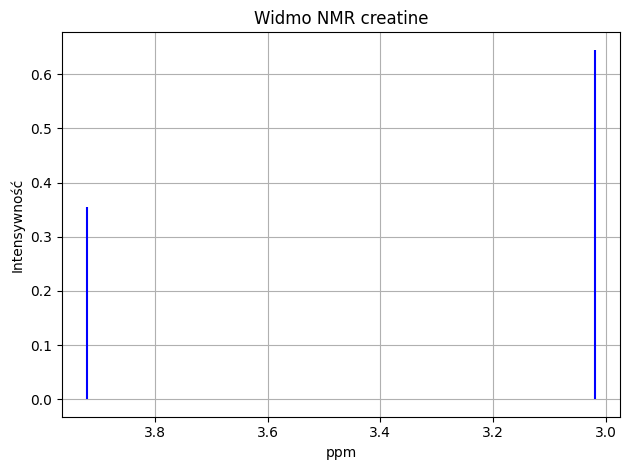

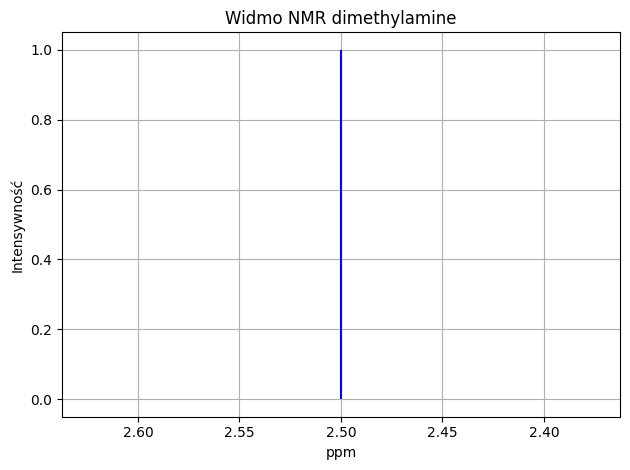

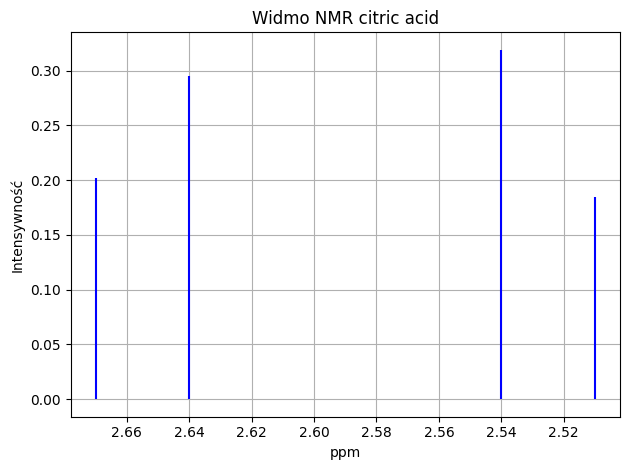

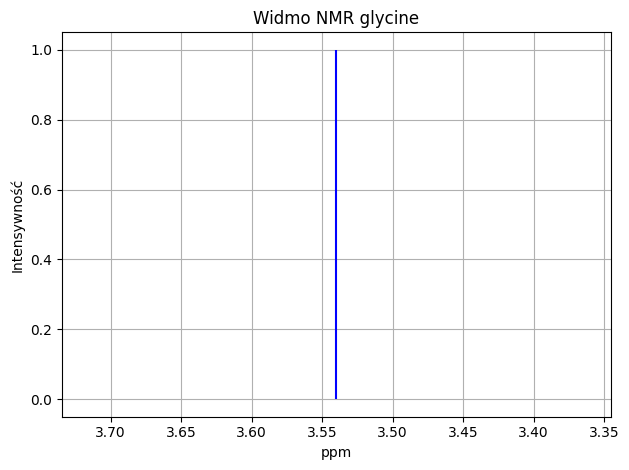

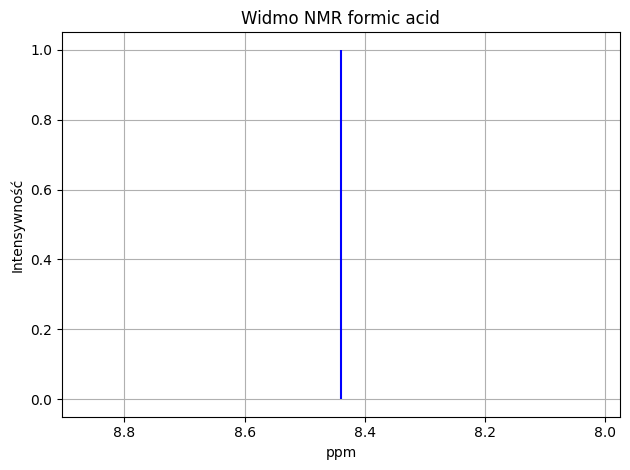

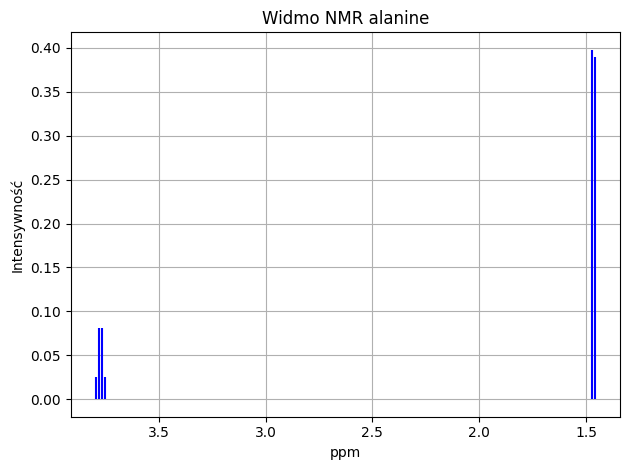

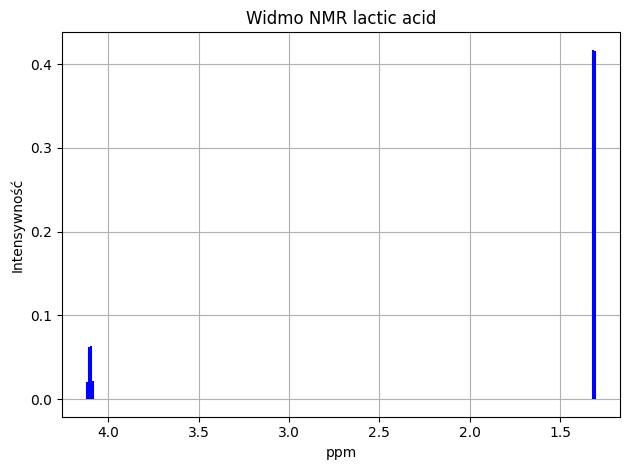

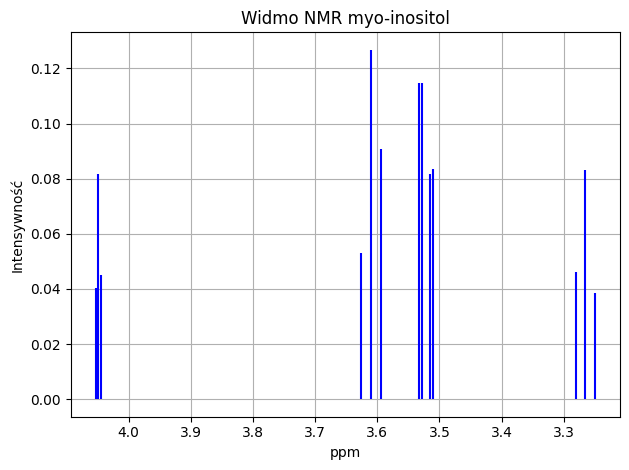

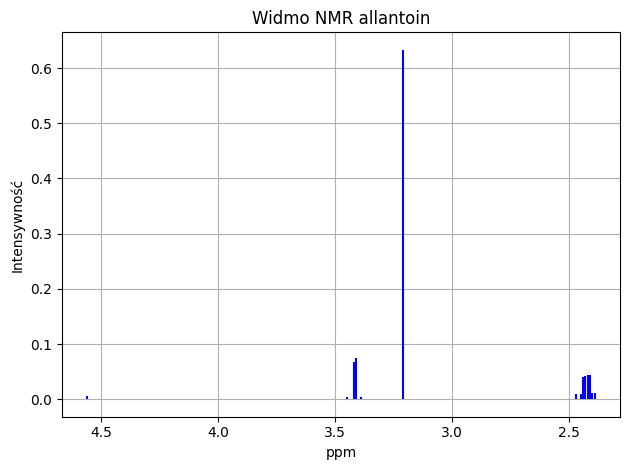

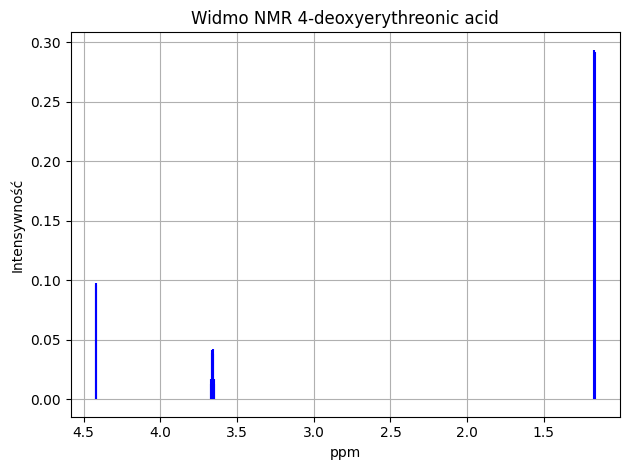

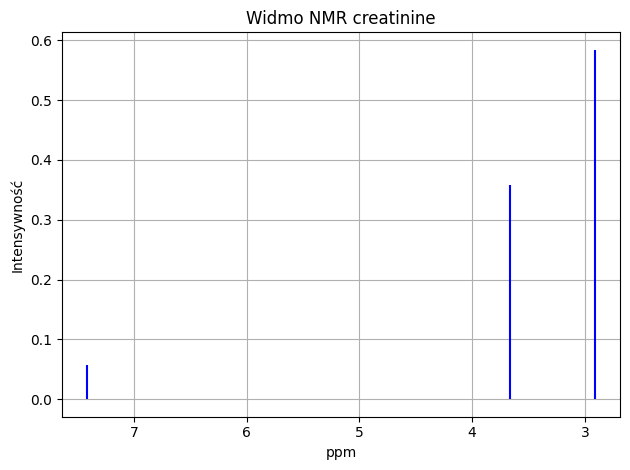

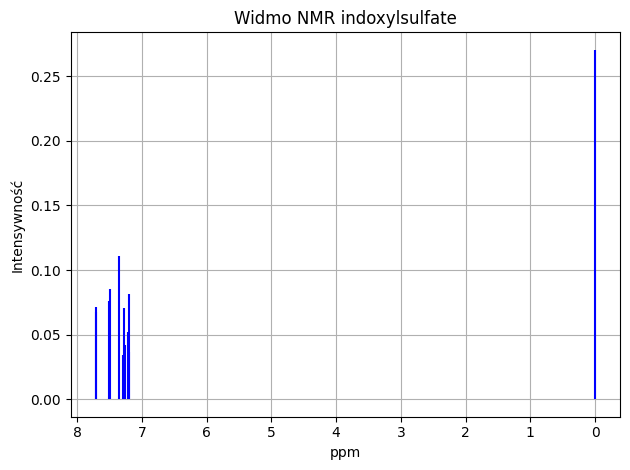

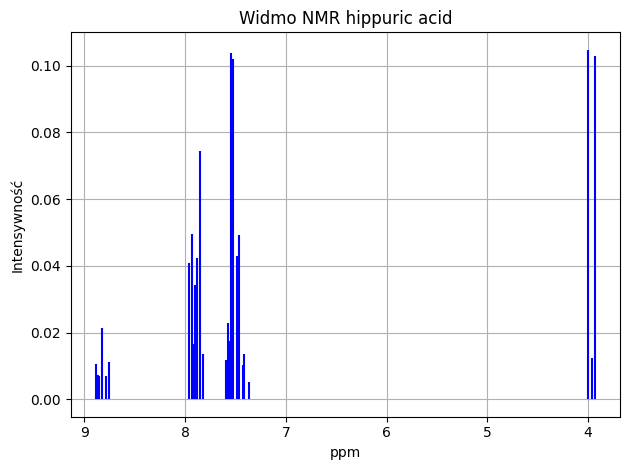

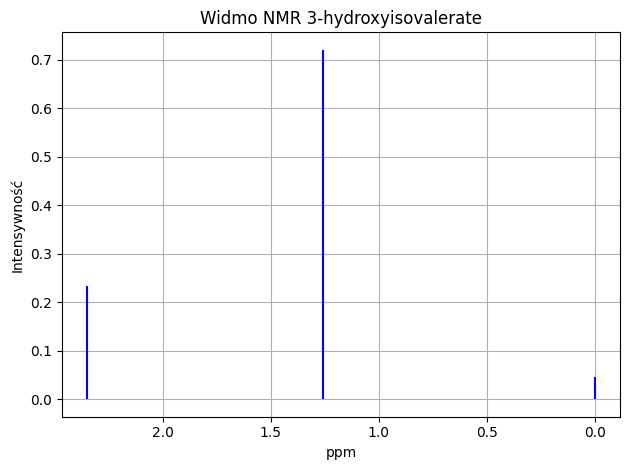

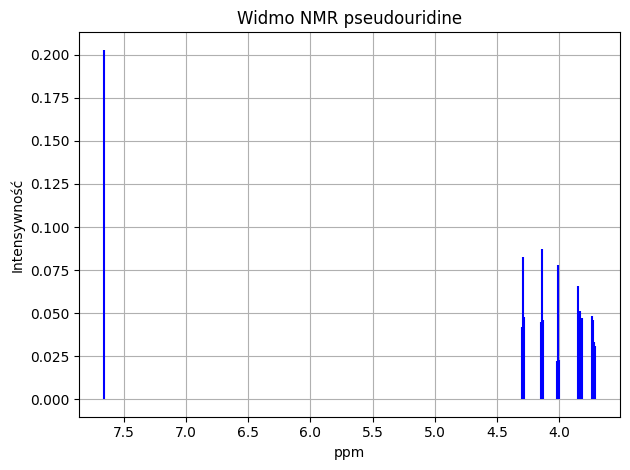

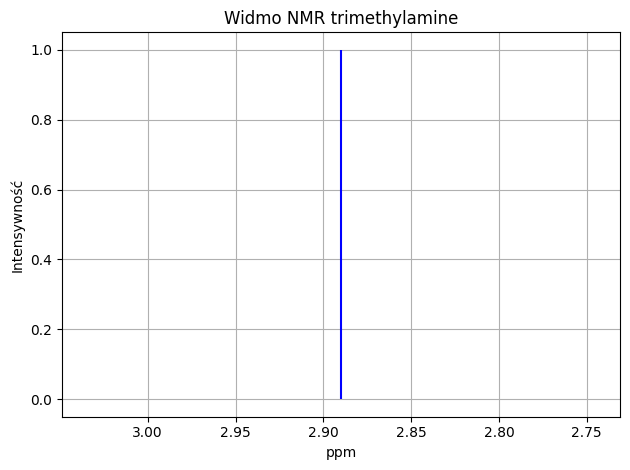

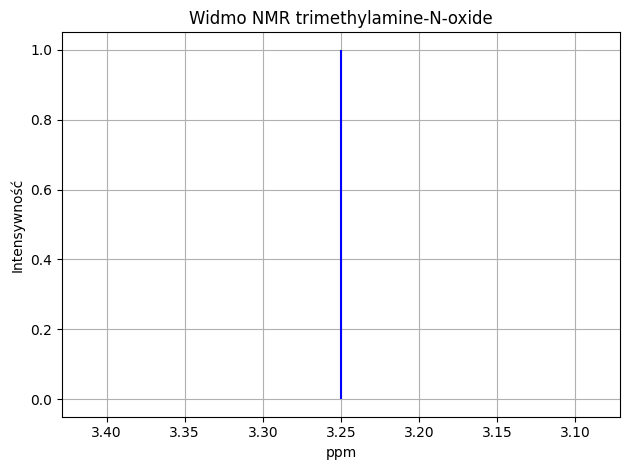

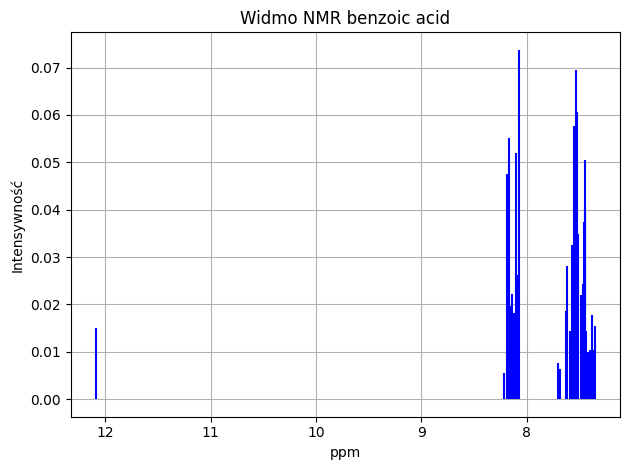

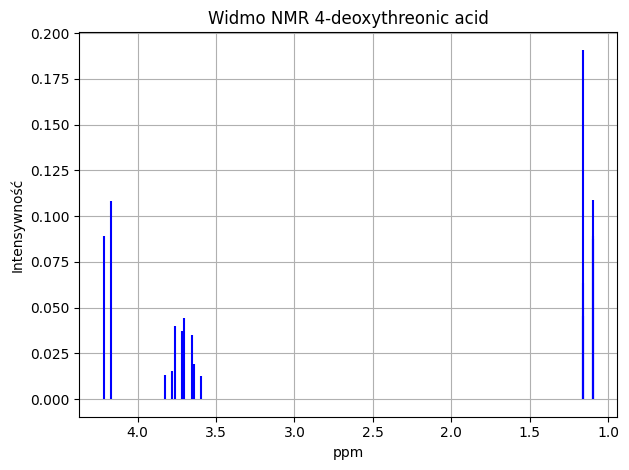

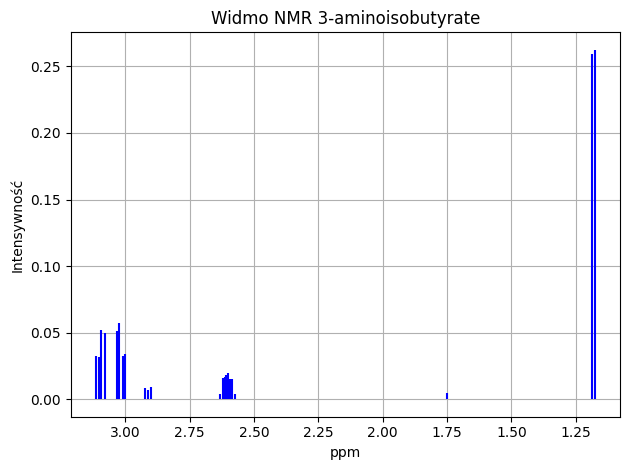

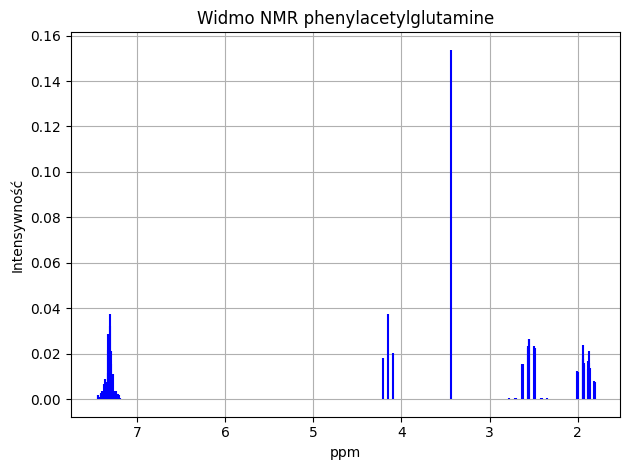

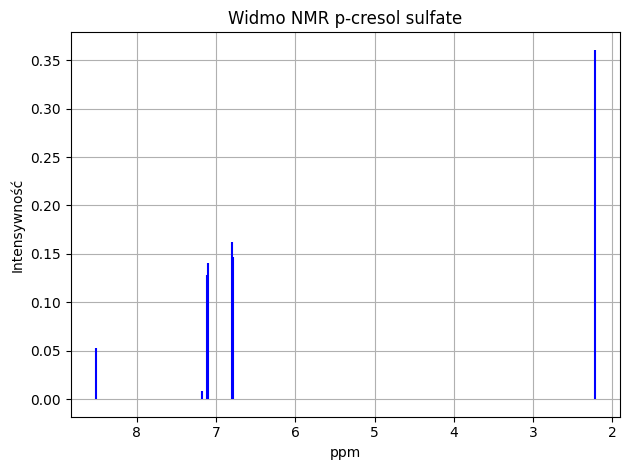

In [9]:
# test plots
for sp in spectra1:
    confs = np.array(sp.confs)
    x = confs[:, 0]  # pozycje pików
    y = confs[:, 1]  # intensywności
    plt.vlines(x, 0, y, color='blue')
    plt.xlabel('ppm')
    plt.ylabel('Intensywność')
    plt.title(f'Widmo NMR {sp.label}')
    plt.gca().invert_xaxis()  # Odwrócenie osi x jak w NMR
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [10]:
## create NMRSpectrum of experimental data

def mix_create(filename: str):
    path = f'C:\\Users\\Anastazja\\HMDB\\Data_urine\\Urine_samples\\{filename}'

    mix = np.loadtxt(path, delimiter=',')

    mix = NMRSpectrum(confs=list(zip(mix[:,0], mix[:,1])), label="Mixture") # protons=None by default
    mix.trim_negative_intensities()
    mix.normalize()

    return mix

In [11]:
## estimate proportions of metabolites
mix = mix_create('1_V5001_D1.csv')

def est_props(kappa_mix, kappa_comp, experimental, spectra, method):
    kappa_mixture = kappa_mix
    kappa_components = kappa_comp

    estimation_result = estimate_proportions(spectrum = experimental,
                                             query = spectra,
                                             MTD = kappa_mixture,
                                             MTD_th = kappa_components,
                                            #  solver = pl.apis.LpSolverDefault,
                                             solver = solver,
                                             verbose=True,
                                             what_to_compare = method, # default
                                             )
    return estimation_result


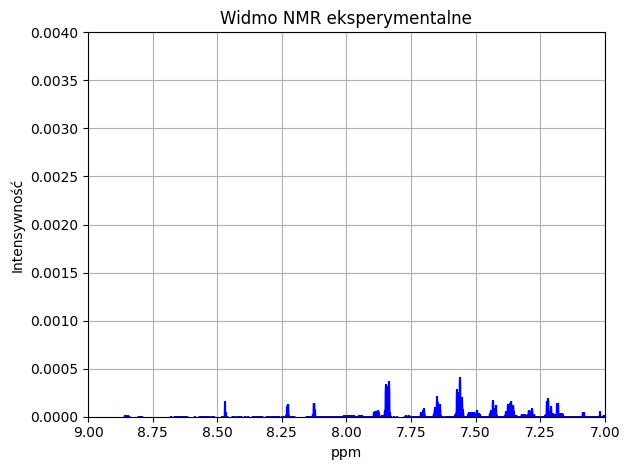

In [12]:
#test plot of mix
confs = np.array(mix.confs)
x = confs[:, 0]  # pozycje pików
y = confs[:, 1]  # intensywności
plt.vlines(x, 0, y, color='blue')
plt.xlabel('ppm')
plt.ylabel('Intensywność')
plt.title(f'Widmo NMR eksperymentalne')
plt.xlim(7,9)
plt.ylim(0,0.004)
plt.gca().invert_xaxis()  # Odwrócenie osi x jak w NMR
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# test estimation
estimation_result = est_props(0.25, 0.22, mix, spectra1, 'area')

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

C:\Users\Anastazja\Desktop\srodowiska\systemy_biol\Lib\site-packages\pulp\pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : LO (linear optimization problem)
  Constraints            : 135560          
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 33885           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 33878
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 60
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.03            
Lin. dep.  - primal attempts        : 1                 successes 

In [13]:
print(estimation_result['proportions'])

[np.float64(0.02990061942218853), np.float64(0.031408008023788396), np.float64(0.149469445294308), np.float64(0.010084716890983746), np.float64(-0.0), np.float64(-0.0), np.float64(0.00574163181676043), np.float64(0.04493490369597237), np.float64(0.01346190906933806), np.float64(0.11072513266910201), np.float64(-0.0), np.float64(0.008078209644460243), np.float64(0.03305352450636251), np.float64(-0.0), np.float64(0.03134169319684084), np.float64(0.042477224307909615), np.float64(-0.0), np.float64(0.02130934981026966), np.float64(0.1885188434930552), np.float64(0.08209302394350336), np.float64(-0.0), np.float64(-0.0), np.float64(-0.0), np.float64(-0.0), np.float64(0.015239700632588945), np.float64(0.0072009648442989465), np.float64(0.009432235336897984), np.float64(0.007455679408402187), np.float64(0.059787980213843954), np.float64(0.01680845125427635), np.float64(0.019886189453627932), np.float64(-0.0), np.float64(-0.0), np.float64(-0.0), np.float64(-0.0)]


In [13]:
# function to rescale intensities in reference spectra
def change_intesities(spectra, proportions):
    new_spectra = []
    for sp, prop in zip(spectra, proportions):


        old_confs = np.array(sp.confs)
        new_ints = old_confs[:,1] * prop

        new_confs = list(zip(old_confs[:,0], new_ints))
        new_spectrum = NMRSpectrum(confs=new_confs, label=sp.label)
        new_spectra.append(new_spectrum)

    return new_spectra



In [15]:
change_intesities(spectra1, estimation_result['proportions'])

In [14]:
### Ex. 2.1
## Function for plotting experimental and library spectra

# mix - experimental spectrum
# spectra - library spectrum
# range = (x_start, x_end, y_height), to show specific part of the plot

def plot_spectra_as_stems(mix, spectra, range=None):
    fig, ax = plt.subplots(figsize=(8, 5))

    colormap = cm.hsv  # Możesz użyć innych palet, np. 'plasma', 'inferno', 'magma'
    more_colors = colormap(np.linspace(0, 1, 400))  # Tworzymy kolory na podstawie palety
    colors = more_colors[::10]

    mix_confs = np.array(mix.confs)
    x_mix = mix_confs[:, 0]
    y_mix = mix_confs[:, 1]

    # Rysujemy mieszane widmo jako czarne słupki
    ax.vlines(x_mix, 0, y_mix, alpha=1, color='black', label='Eksperymentalne', zorder=2)

    for i, sp in enumerate(spectra):
        confs = np.array(sp.confs)
        x = confs[:, 0]  # pozycje pików
        y = confs[:, 1]  # intensywności


        lb = sp.label
        color = colors[i]

        ax.vlines(x, 0, y, alpha=0.7, label=lb, color=color, zorder=3)

    if range != None:
        ax.set_xlim(range[0], range[1])
        ax.set_ylim(0,range[2])

    ax.invert_xaxis()
    ax.set_xlabel("Pozycja piku")
    ax.set_ylabel("Intensywność")
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=4,
    fontsize='small')
    plt.tight_layout()
    plt.show()
#plot_spectra_as_stems(mix,spectra,labels=True, range=(3,4,0.01))

In [15]:
### Ex. 2.2 Estimation of proportions for selected experimental spectra
## Test different solvers
# selected experimental spectra

mix10 = mix_create('10_V5001_D10.csv')
mix100 = mix_create('100_V5001_D100.csv')
mix200 = mix_create('197_V5001_D200.csv')

mixes = [mix10, mix100, mix200]


In [10]:
solver = pl.PULP_CBC_CMD()
print(solver)

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

C:\Users\Anastazja\Desktop\srodowiska\systemy_biol\Lib\site-packages\pulp\pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.9557256886000001
Noise proportion in mixture's spectrum: 0.044274310355000054
Total explanation: 0.9999999989550001
Noise proportion in combination of components' spectra: 0.0050625098
Wykres dla próbki <masserstein.nmr_spectrum.NMRSpectrum object at 0x0000017D53EA6350>, obliczone solverem PULP


Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

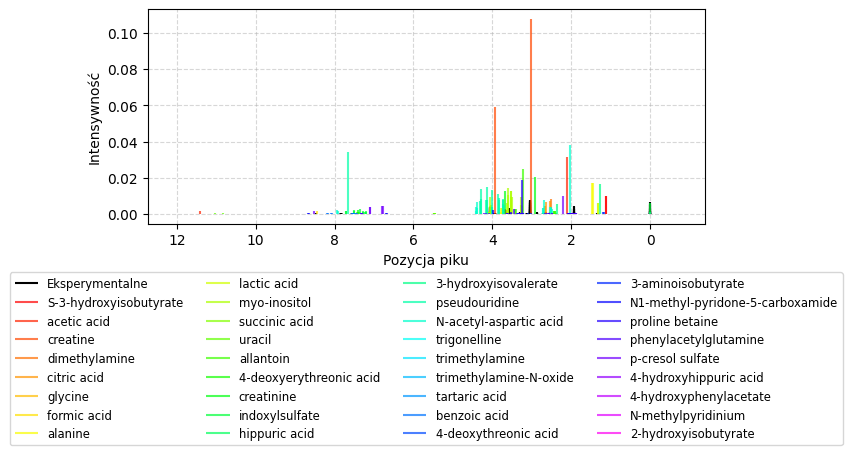

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

In [16]:
for elt in mixes:
    estimation_result = est_props(0.25, 0.22, elt, spectra1, 'area')
    edited_spectra = change_intesities(spectra1, estimation_result['proportions'])
    print(f'Wykres dla próbki {elt}, obliczone solverem PULP')
    plot_spectra_as_stems(elt, edited_spectra, range=None)

In [20]:
solver = pl.GUROBI(env=env, msg=False)
print(solver)

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

C:\Users\Anastazja\Desktop\srodowiska\systemy_biol\Lib\site-packages\pulp\pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.9557257604430001
Noise proportion in mixture's spectrum: 0.04427423959299996
Total explanation: 1.000000000036
Noise proportion in combination of components' spectra: 0.005062305775
Wykres dla próbki <masserstein.nmr_spectrum.NMRSpectrum object at 0x0000017D53EA6350>, obliczone solverem GUROBI


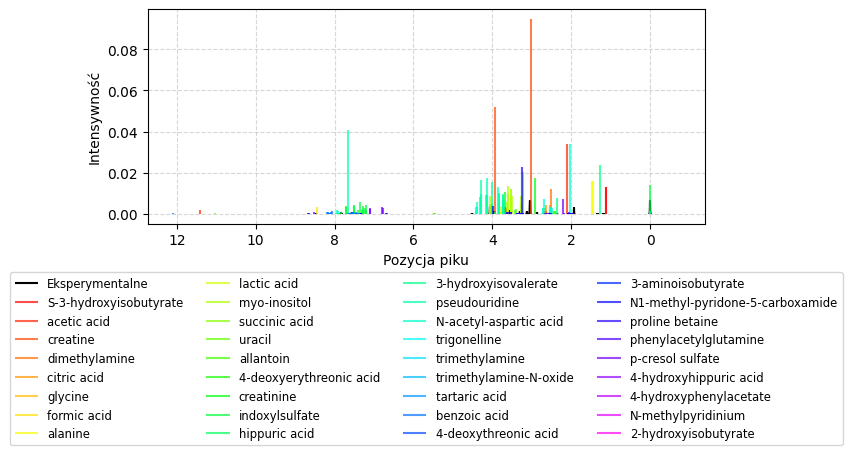

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

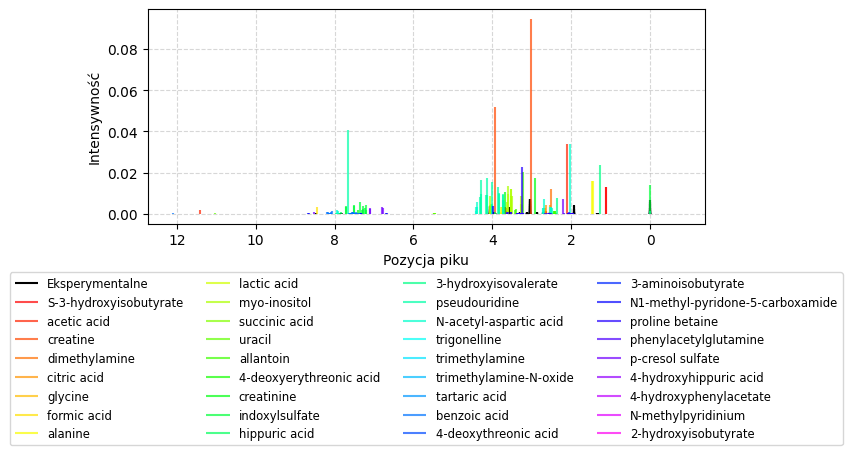

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

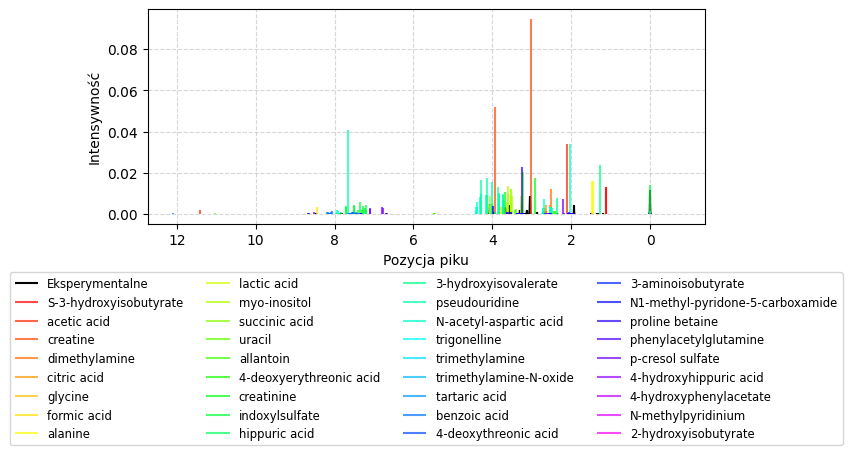

In [21]:
for elt in mixes:
    estimation_result = est_props(0.25, 0.22, elt, spectra1, 'area')
    edited_spectra = change_intesities(spectra1, estimation_result['proportions'])
    print(f'Wykres dla próbki {elt}, obliczone solverem GUROBI')
    plot_spectra_as_stems(elt, edited_spectra, range=None)

In [24]:
solver = pl.MOSEK()
print(solver)

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

C:\Users\Anastazja\Desktop\srodowiska\systemy_biol\Lib\site-packages\pulp\pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : LO (linear optimization problem)
  Constraints            : 135560          
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 33885           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 33879
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 59
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes 

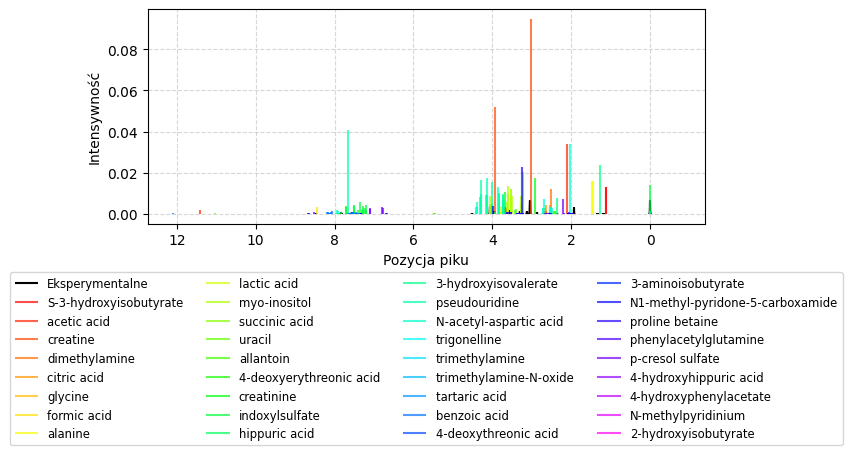

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

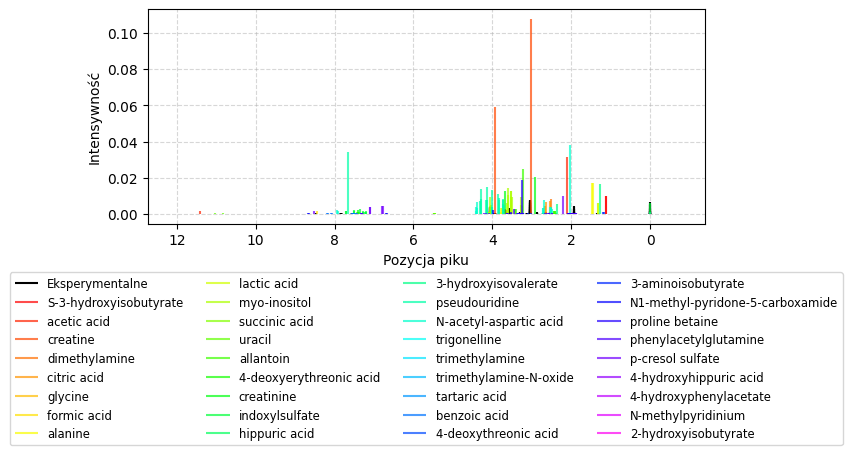

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

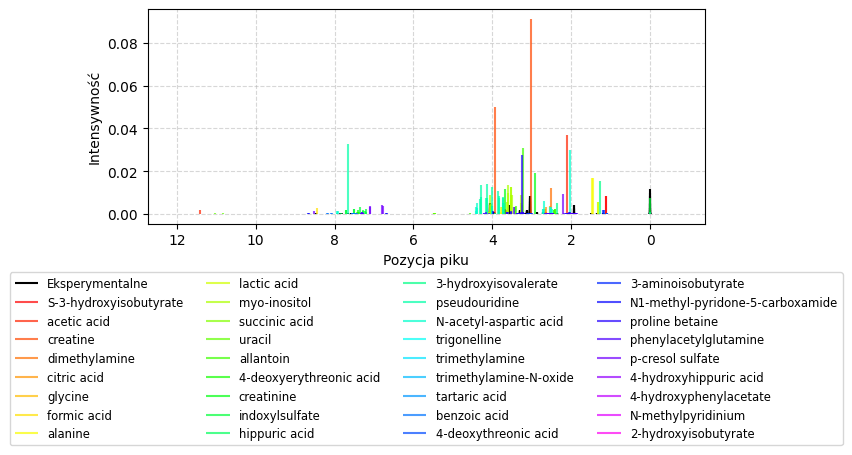

In [25]:
for elt in mixes:
    estimation_result = est_props(0.25, 0.22, elt, spectra1, 'area')
    edited_spectra = change_intesities(spectra1, estimation_result['proportions'])
    print(f'Wykres dla próbki {elt}, obliczone solverem MOSEK')
    plot_spectra_as_stems(elt, edited_spectra, range=None)

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

C:\Users\Anastazja\Desktop\srodowiska\systemy_biol\Lib\site-packages\pulp\pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : LO (linear optimization problem)
  Constraints            : 137160          
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 34285           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 34276
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 62
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.05            
Lin. dep.  - primal attempts        : 1                 successes 

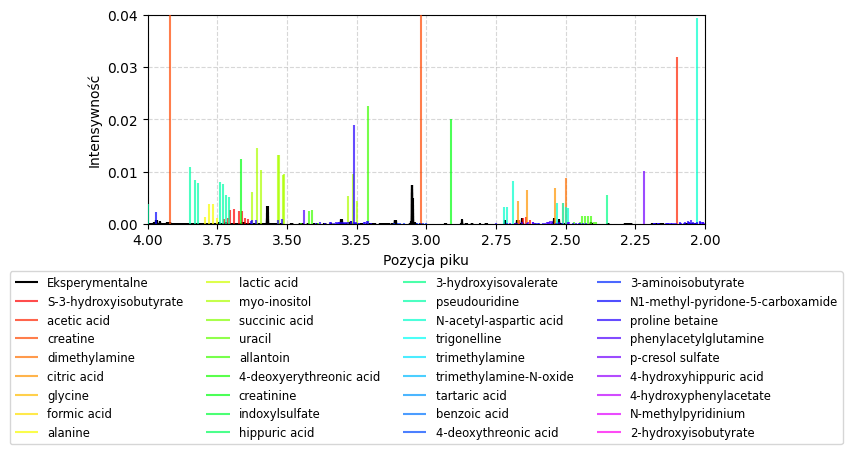

In [99]:
### Ex. 2.4 Find the best kappa values
# kappa_mix, kappa_comp
# for comp: looking at HMDB0003911 experimental spectrum - 0.05
# the same looking at HMDB0013678 predicted 100 MHz
# for curiosity also chose 0.1
# looking at mix spectrum in ppm range (7,9) - 0.15, 0.2


#kappa_to_test = [(0.15, 0.05), (0.15, 0.1)]
kappa_to_test = [(0.3, 0.3)]
for kappas in kappa_to_test:
    estimation_result = est_props(kappas[0],kappas[1], mix100, spectra1, 'area')
    edited_spectra = change_intesities(spectra1, estimation_result['proportions'])
    print(f'Wykres dla próbki {kappas[0]=}, {kappas[1]=}, obliczone solverem {solver}')
    plot_spectra_as_stems(mix100, edited_spectra, range=(2, 4, 0.04))

## Estimation of proportions of metabolites - library 1

In [16]:
### Ex. 2.5

folder_path = 'C:\\Users\\Anastazja\\HMDB\\Data_urine\\Urine_samples'

props_for_exps = {}
for filename in os.listdir(folder_path):
    if 'D' in filename:
        day = filename.split('D', 1)[1]
        day = day[:-4]
    else:
        day = '1000'

    exp = mix_create(filename)
    estimation_result = est_props(0.3, 0.3 , exp, spectra1, 'area')
    props_for_exps[day] = estimation_result['proportions']



Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 15), (0.0, 2.35, 17), (1.098922729492188, 4.215255737304688, 25), (1.106, 3.727, 0), (1.166961669921875, 4.422470092773438, 13), (1.175, 3.116, 26), (1.259994506835937, 1.309982299804687, 34), (1.3097, 4.1163, 8), (1.459, 3.795, 7), (1.78668212890625, 3.67254638671875, 28), (1.803558349609375, 7.466705322265625, 29), (2.03, 7.93, 19), (2.099, 11.417, 1), (2.1400146484375, 6.82861328125, 32), (2.22, 8.52, 30), (2.39, 4.56, 12), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.672, 4.874, 10), (2.89, 2.89, 21), (2.913, 7.415, 14), (3.02, 3.92, 2), (3.2495, 4.0535, 9), (3.25, 3.25, 22), (3.54, 3.54, 5), (3.71, 7.66, 18), (3.931, 8.889, 16), (3.959976196289063, 7.539337158203125, 31), (3.970016479492188, 8.660964965820312, 27), (4.336, 4.336, 23), (4.420013427734375, 8.824066162109375, 33), (4.498, 9.158, 20), (5.442, 11.022, 11), (7.351, 12.094, 24), (8.44, 8.44, 6)]
Number of chunks: 1
ChunkID

C:\Users\Anastazja\Desktop\srodowiska\systemy_biol\Lib\site-packages\pulp\pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : LO (linear optimization problem)
  Constraints            : 137160          
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 34285           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 34276
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 62
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.03            
Lin. dep.  - primal attempts        : 1                 successes 

In [17]:
days = sorted(props_for_exps.keys(), key=int)
print(days)

['1', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120', '130', '140', '150', '160', '170', '180', '190', '200', '210', '220', '230', '240', '250', '254', '713', '716', '1000']


### Changes in the proportions of the metabolites over time during the experiment

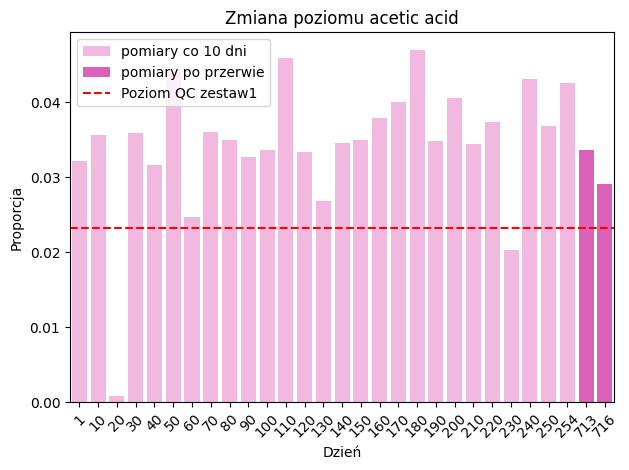

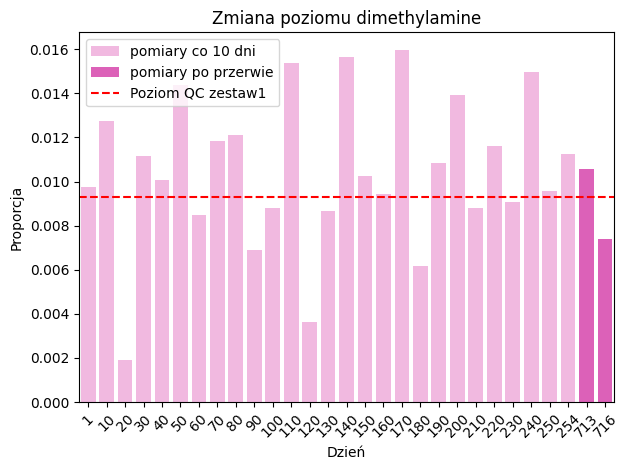

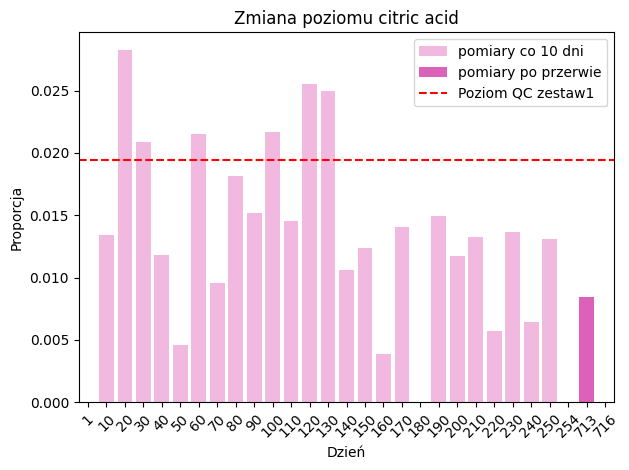

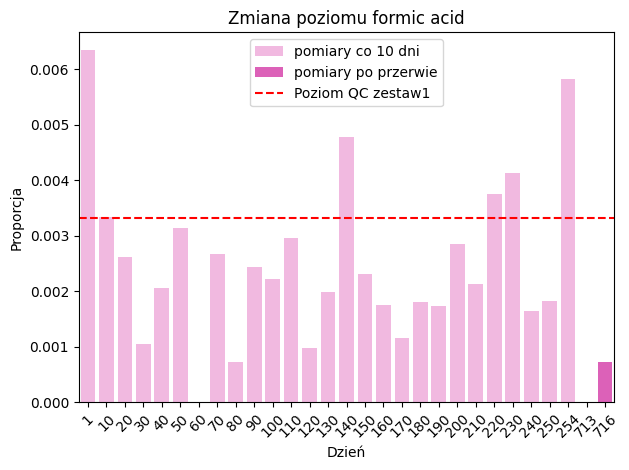

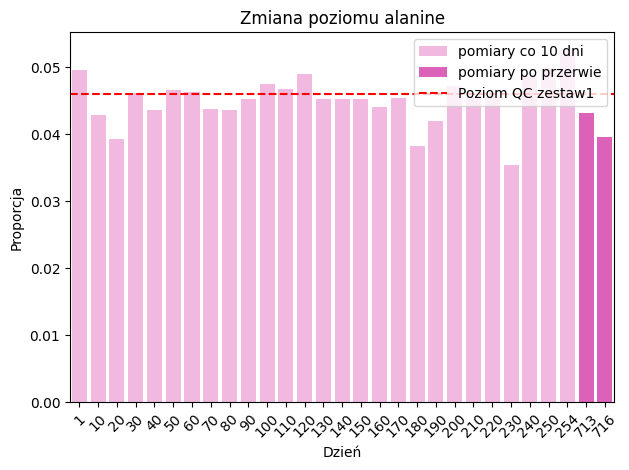

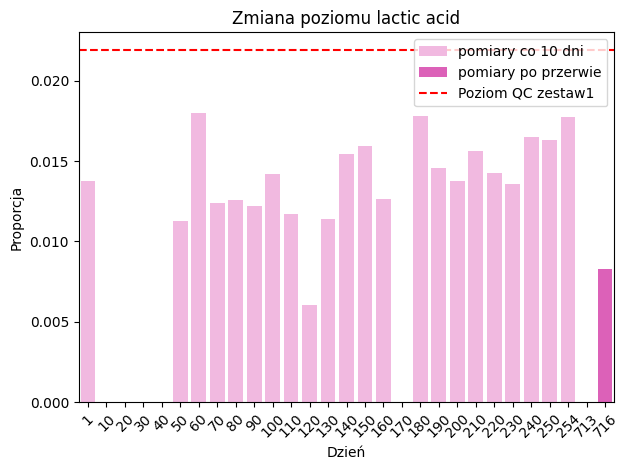

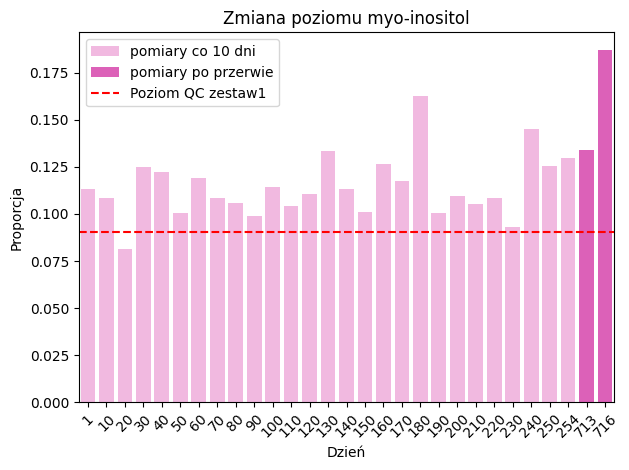

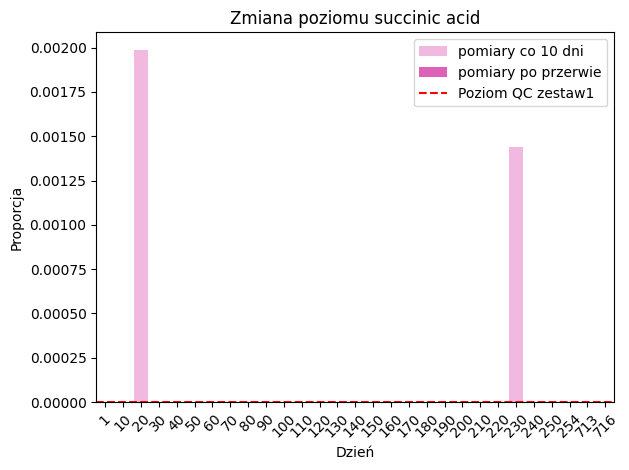

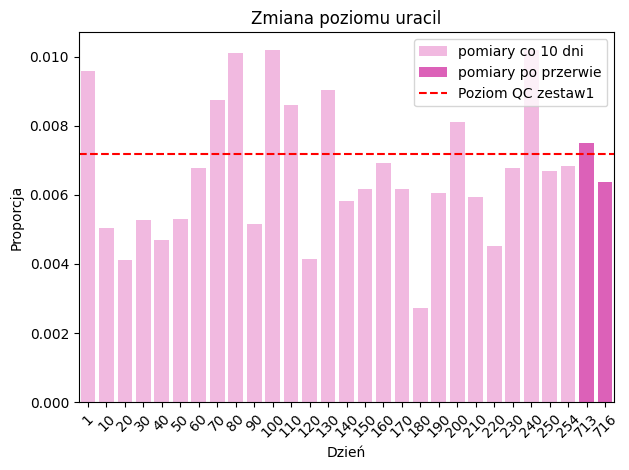

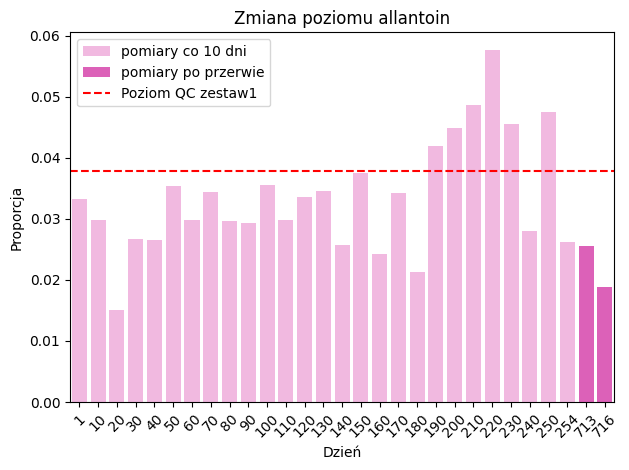

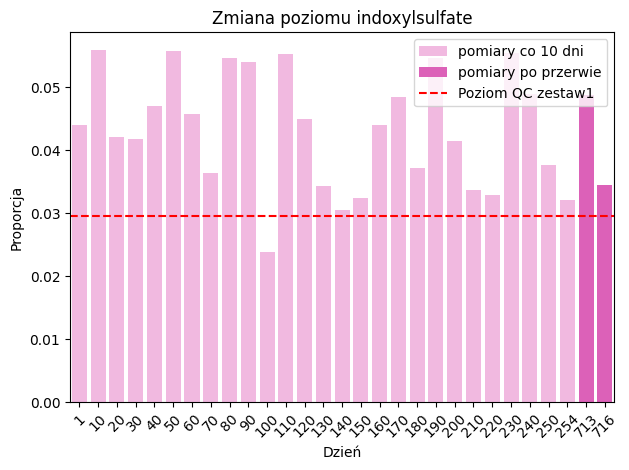

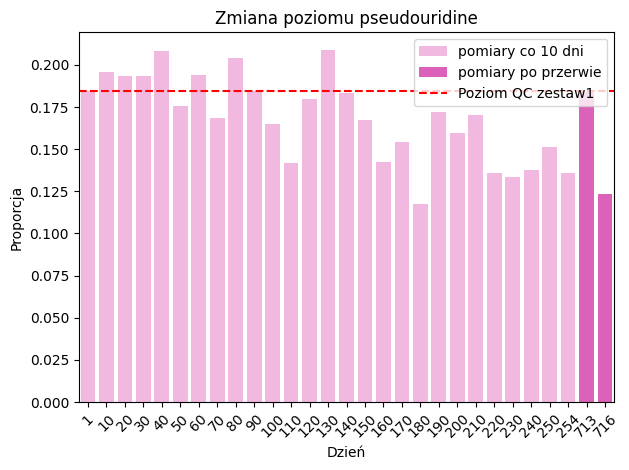

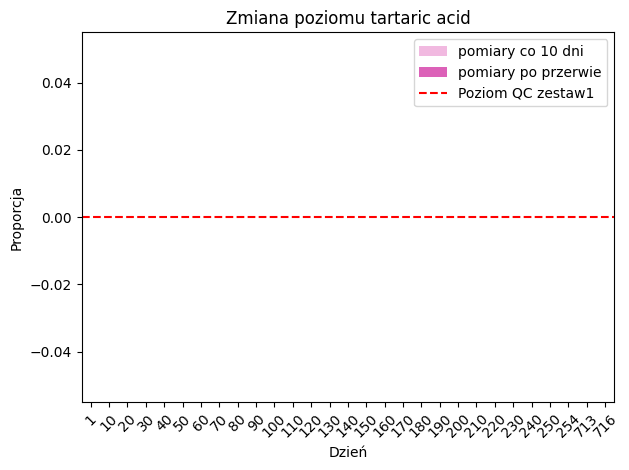

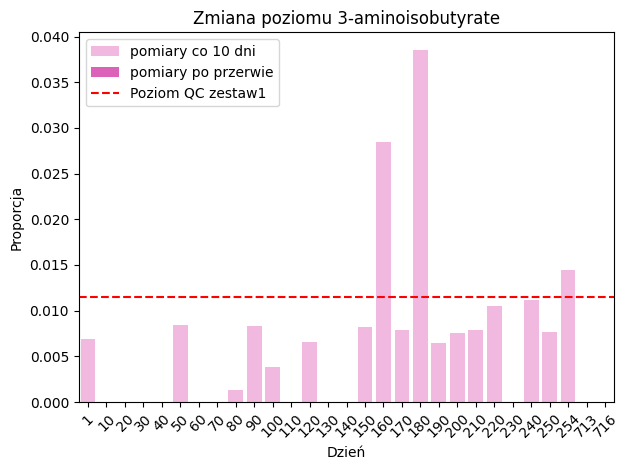

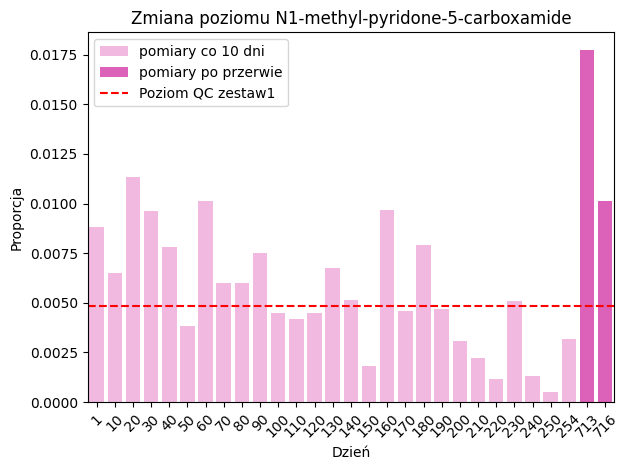

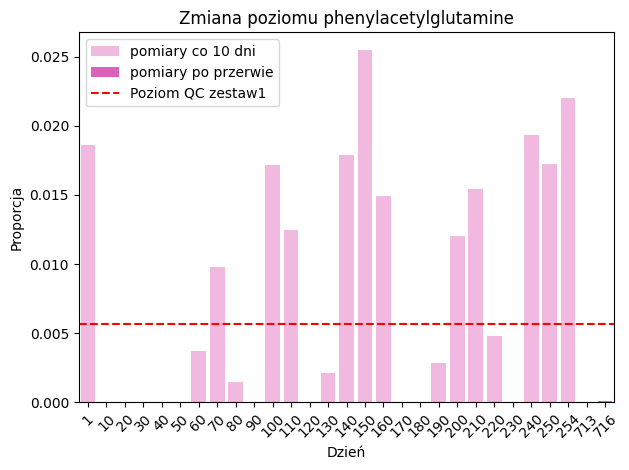

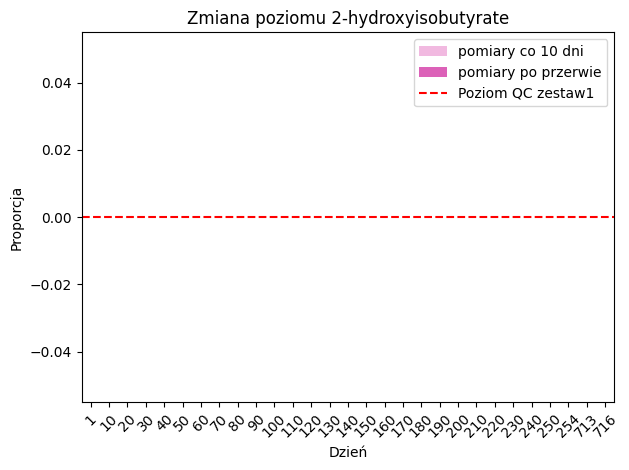

In [92]:
import seaborn as sns

props_metab = {}
for i, metabolite in enumerate(spectra1):

    props_metab[metabolite.label] = [props_for_exps[d][i] for d in days]

    data = pd.DataFrame({
            'dzień': days[:-1],
            'poziom': props_metab[metabolite.label][:-1],
            'zestaw':['Zestaw 1']*len(days[:-1]),
            'grupa': ['pomiary co 10 dni'] * (len(days) - 3) + ['pomiary po przerwie', 'pomiary po przerwie']
        })

    QC1 = props_metab[metabolite.label][-1]
    paleta1 = sns.color_palette('pastel')
    paleta2 = sns.color_palette('bright')
    color1 = paleta1[6]
    color2 = paleta2[6]


    sns.barplot(data=data, x='dzień', y='poziom', hue='grupa', palette=[color1, color2])
    plt.axhline(y=QC1, color='red', linestyle='--', label='Poziom QC zestaw1')

    plt.title(f'Zmiana poziomu {metabolite.label}')
    plt.ylabel('Proporcja')
    plt.xlabel('Dzień')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()


## New reference library (2)

In [29]:
### Ex. 3

mix10 = mix_create('10_V5001_D10.csv')
mix60 = mix_create('60_V5001_D60.csv')
mix120 = mix_create('120_V5001_D120.csv')
mix200 = mix_create('197_V5001_D200.csv')
mix716 = mix_create('255_V5001_D716.csv')
mixQc = mix_create('1541_QC.csv')

In [25]:
### read chosen files of selected metabolites

df = pd.read_excel('C:\\Users\\Anastazja\\HMDB\\selected_metabolites2.xlsx')
# Edit Data Frame, save only needed rows

df = df.iloc[:, 0:4]

chosen_files2 = df['chosen_file'].tolist()

In [21]:
print(len(chosen_files2))

35


In [26]:
folder_path = 'C:\\Users\\Anastazja\\HMDB\\selected_met_spectra2'

# list of paths to selected metabolites' csv files
chosen_paths2 = []

for file in chosen_files2:
    path = f'{folder_path}\\{file}'
    chosen_paths2.append(path)

metabolites_names2 = df['name'].tolist()

In [27]:
# create new list of spectra - spectra2

spectra2 = []
for name, path in zip(metabolites_names2, chosen_paths2):
    df = pd.read_csv(path)
    conf1 = df['peak_position_ppm'].tolist()
    conf2 = df['intensity'].tolist()

    spectrum = NMRSpectrum(confs=list(zip(conf1, conf2)),
                           label=name)

    spectrum.trim_negative_intensities()
    spectrum.normalize()
    spectra2.append(spectrum)

In [30]:
# selected days of experiment
mixes = [mix10, mix60, mix120, mix200, mix716, mixQc]
days2 = [10, 60, 120, 200, 716, 1000]

In [31]:
# calculate proportions for selected days
props_for_exps2 = {}

for mix in zip(mixes, days2):
    estimation_result = est_props(0.3, 0.3 , mix[0], spectra2, 'area')
    props_for_exps2[mix[1]] = estimation_result['proportions']


Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.0, 7.719, 12), (0.0, 2.35, 14), (0.969, 3.605, 29), (1.098922729492188, 4.215255737304688, 20), (1.106, 3.727, 0), (1.175, 3.116, 21), (1.3097, 4.1163, 7), (1.459, 3.795, 6), (1.78668212890625, 3.67254638671875, 23), (1.803558349609375, 7.466705322265625, 24), (2.029998779296875, 8.663955688476562, 31), (2.03, 7.93, 16), (2.099, 11.417, 1), (2.22, 8.52, 25), (2.39, 4.56, 10), (2.5, 2.5, 3), (2.51, 2.67, 4), (2.913, 7.415, 11), (3.02, 3.92, 2), (3.189, 4.068, 32), (3.219, 5.226, 28), (3.2495, 4.0535, 8), (3.25, 3.25, 17), (3.626, 7.799, 33), (3.634, 3.853, 30), (3.71, 7.66, 15), (3.81, 5.41, 34), (3.931, 8.889, 13), (3.959976196289063, 7.539337158203125, 26), (3.970016479492188, 8.660964965820312, 22), (4.336, 4.336, 18), (4.420013427734375, 8.824066162109375, 27), (5.442, 11.022, 9), (7.351, 12.094, 19), (8.44, 8.44, 5)]
Number of chunks: 1
ChunkIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

C:\Users\Anastazja\Desktop\srodowiska\systemy_biol\Lib\site-packages\pulp\pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : LO (linear optimization problem)
  Constraints            : 137264          
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 34311           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 34302
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 120
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes

In [80]:
# save for each metabolite list of proportions on selected days

props_metab2 = {}
for i, sp in enumerate(spectra2):
    props_metab2[sp.label] = []
    for d in days2:
        props_metab2[sp.label].append(props_for_exps2[d][i])


In [81]:
print(props_metab2)

{'S-3-hydroxyisobutyrate': [np.float64(0.00736165875788461), np.float64(0.006136615698067217), np.float64(0.0056487012578716606), np.float64(0.007376848322860505), np.float64(0.0022352976092812338), np.float64(0.007525514458813393)], 'acetic acid': [np.float64(0.030662091502168334), np.float64(0.021732435478520683), np.float64(0.025738345593416503), np.float64(0.03810594223398258), np.float64(0.019422640279777185), np.float64(0.020866358857150984)], 'creatine': [np.float64(0.12056745477964716), np.float64(0.13498909622005506), np.float64(0.14101063448617737), np.float64(0.12378782360511452), np.float64(0.04933588971265319), np.float64(0.1398458441035761)], 'dimethylamine': [np.float64(0.016255838229427673), np.float64(0.010765487561861135), np.float64(0.007548648198621548), np.float64(0.021013918806810326), np.float64(0.0033429513730277166), np.float64(0.013354928722628067)], 'citric acid': [np.float64(0.01842614569567761), np.float64(0.0260958425748246), np.float64(0.03042620088991158

In [79]:
print(props_for_exps2)

{10: [np.float64(0.00736165875788461), np.float64(0.030662091502168334), np.float64(0.12056745477964716), np.float64(0.016255838229427673), np.float64(0.01842614569567761), np.float64(0.0025277285337967016), np.float64(0.03579497566748708), np.float64(0.013432032883504847), np.float64(0.05517562442317186), np.float64(-0.0), np.float64(0.009944582758906913), np.float64(0.026748289402019704), np.float64(0.060421904102887794), np.float64(0.034843592734478644), np.float64(0.022953272046271015), np.float64(0.1151406895028386), np.float64(0.0795044739726464), np.float64(-0.0), np.float64(-0.0), np.float64(0.014106034908057018), np.float64(-0.0), np.float64(0.01654123350583407), np.float64(-0.0), np.float64(0.07344301254948882), np.float64(-0.0), np.float64(0.020478263572994072), np.float64(-0.0), np.float64(-0.0), np.float64(0.011519967680613495), np.float64(0.016817337802388848), np.float64(0.07042834827280291), np.float64(0.004792271137291235), np.float64(0.04821830747693764), np.float64(-

Wykres dla próbki <masserstein.nmr_spectrum.NMRSpectrum object at 0x0000024B88EB1750>, obliczone solverem MOSEK


Wykres dla próbki <masserstein.nmr_spectrum.NMRSpectrum object at 0x0000024B8B5381D0>, obliczone solverem MOSEK


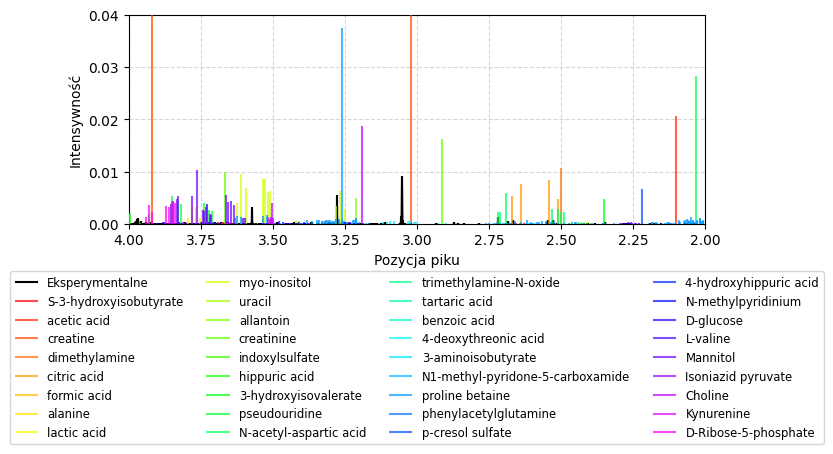

Wykres dla próbki <masserstein.nmr_spectrum.NMRSpectrum object at 0x0000024B8BD40D50>, obliczone solverem MOSEK


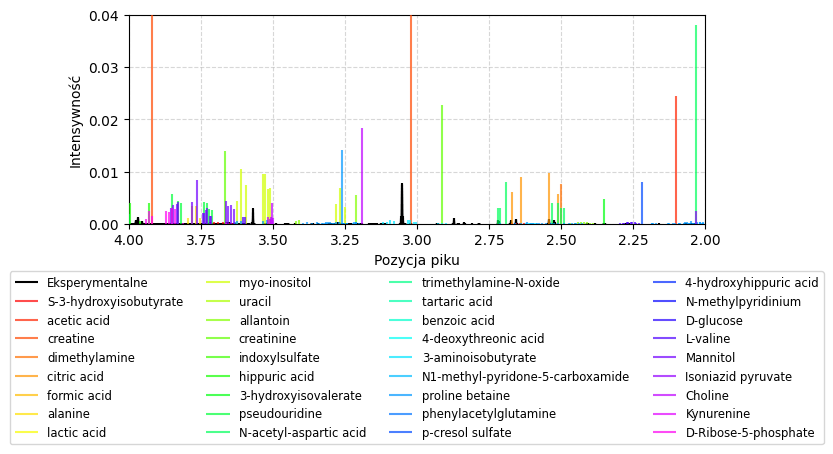

Wykres dla próbki <masserstein.nmr_spectrum.NMRSpectrum object at 0x0000024B8DEA60D0>, obliczone solverem MOSEK


Wykres dla próbki <masserstein.nmr_spectrum.NMRSpectrum object at 0x0000024B8A4BB490>, obliczone solverem MOSEK


Wykres dla próbki <masserstein.nmr_spectrum.NMRSpectrum object at 0x0000024B8B630850>, obliczone solverem MOSEK


In [98]:
# plot spectra mix vs reference
for mix in zip(mixes, days2):
    edited_spectra = change_intesities(spectra2, props_for_exps2[mix[1]])
    print(f'Wykres dla próbki {mix[0]}, obliczone solverem MOSEK')
    plot_spectra_as_stems(mix[0], edited_spectra, range=(2,4,0.04))

In [52]:
# detect the same metabolites in spectra1 and spectra2 (for plotting)
pairs = []
solo = []
for sp2 in spectra2:
    found = False
    for sp1 in spectra1:
        if sp2.label == sp1.label:
            found = True
            pairs.append((sp1, sp2))
            break
    if not found: solo.append(sp2)


### Comparison of metabolite proportion changes on selected days between two reference libraries

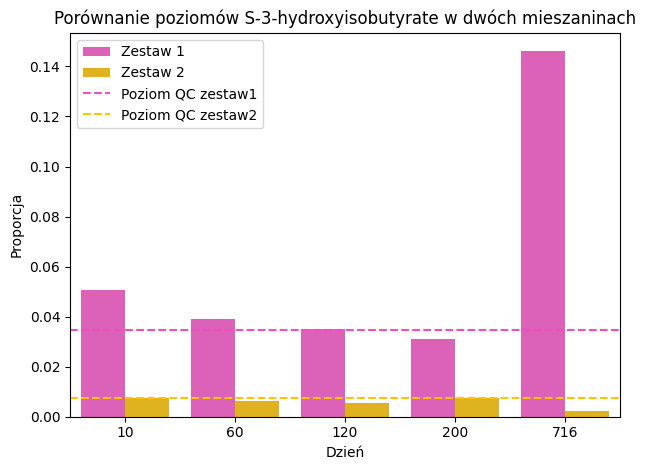

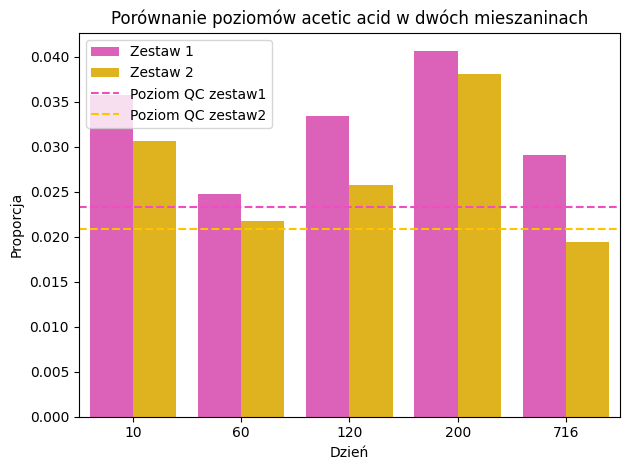

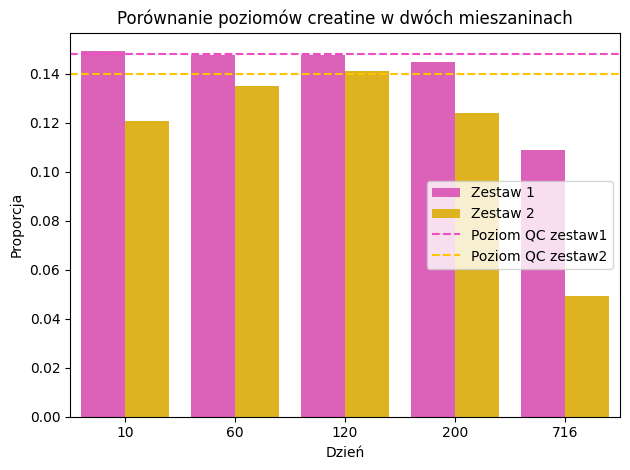

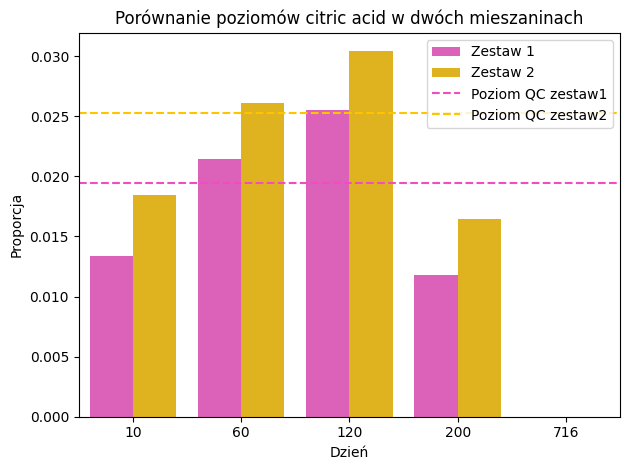

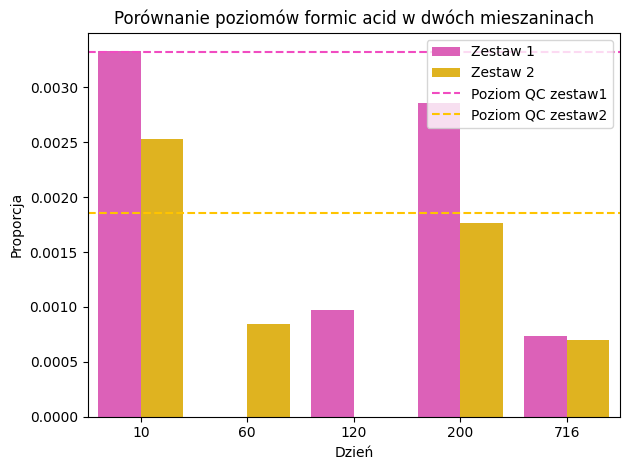

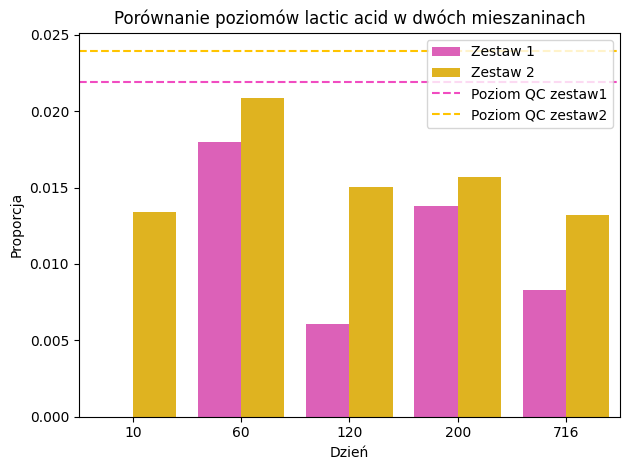

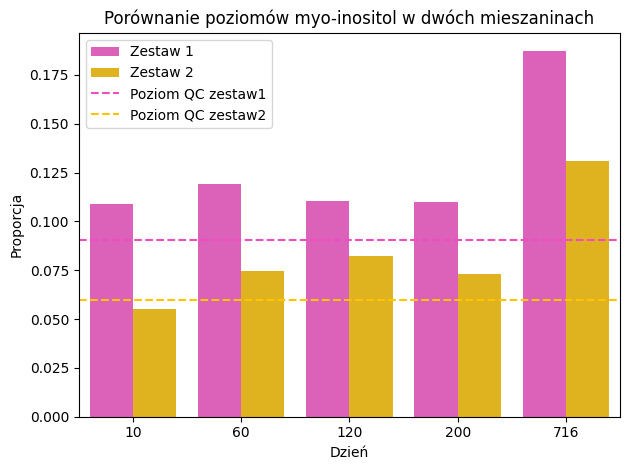

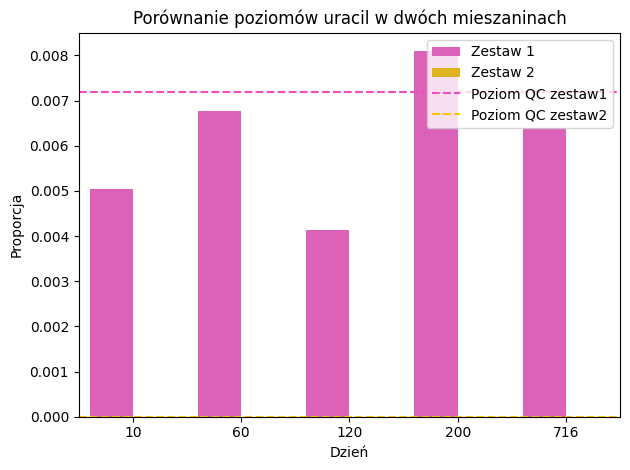

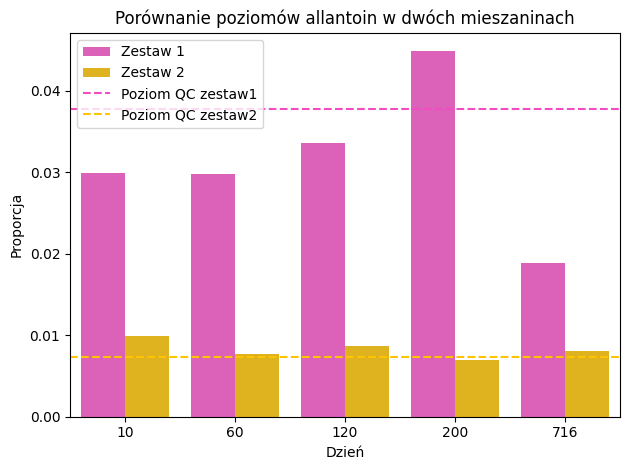

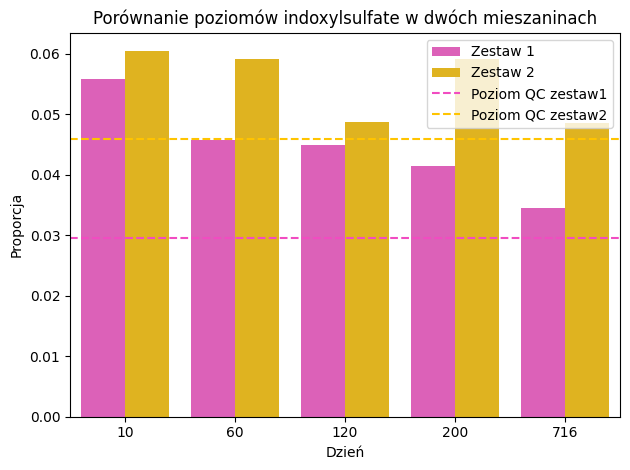

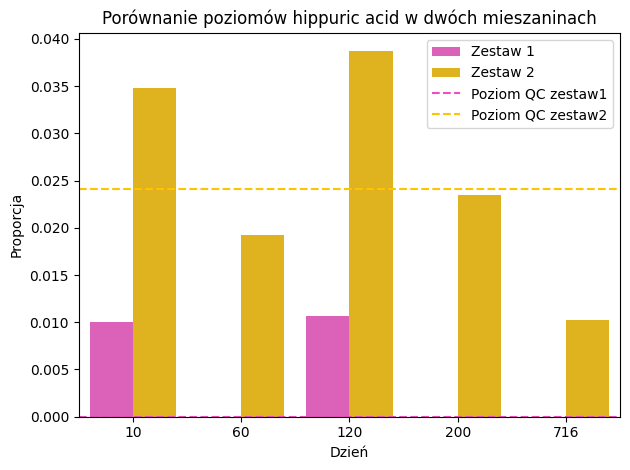

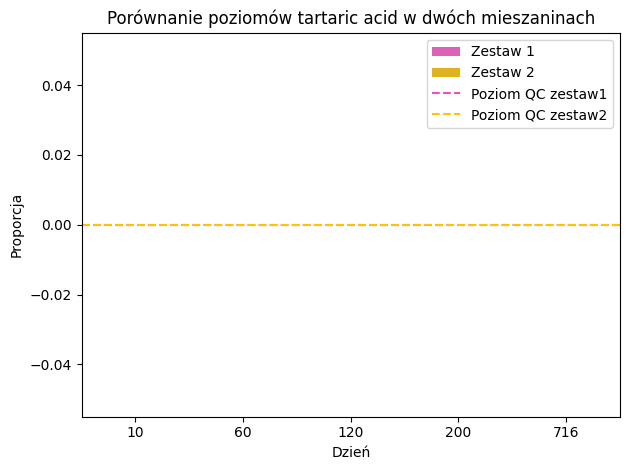

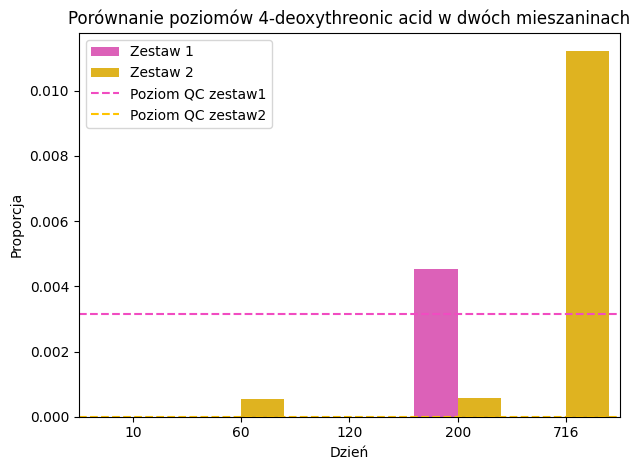

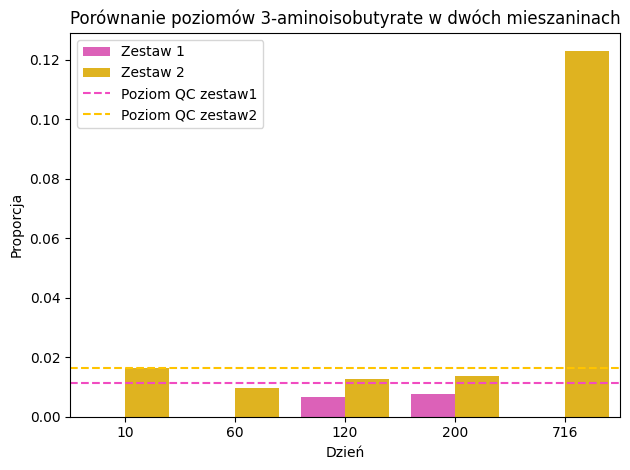

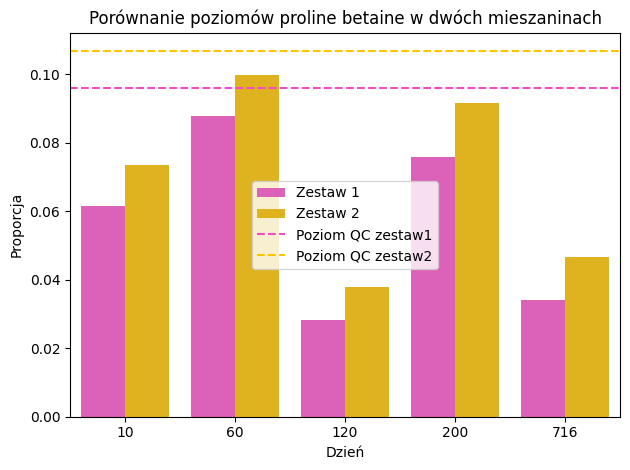

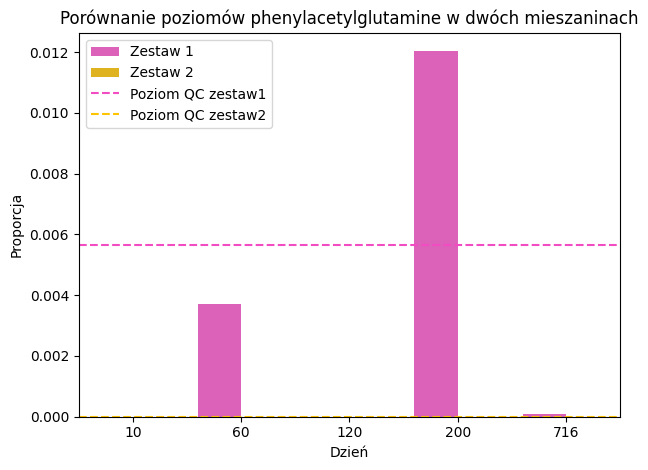

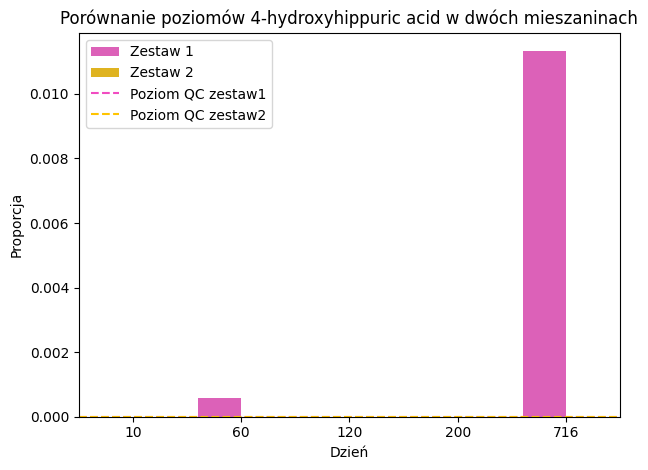

In [96]:
import seaborn as sns

#pairs = (sp1, sp2)
for i, pair in enumerate(pairs):

        props_metab1 = [props_metab[pair[0].label][j] for j in [1, 6, 12, 20, 28, 29]]
        props_metab2_2 = props_metab2[pair[1].label]

        QC1 = props_metab1[-1]
        QC2 = props_metab2_2[-1]

        data = pd.DataFrame({
            'dzień': days2[:-1] * 2,
            'poziom': props_metab1[:-1] + props_metab2_2[:-1],
            'zestaw':['Zestaw 1']*len(days2[:-1]) +['Zestaw 2']*len(days2[:-1])
        })
        paleta = sns.color_palette('bright')
        color1 = paleta[6]
        color2 = paleta[8]

        sns.barplot(data=data, x='dzień', y='poziom', hue='zestaw', palette=[color1, color2])
        plt.axhline(y=QC1, color=color1, linestyle='--', label='Poziom QC zestaw1')
        plt.axhline(y=QC2, color=color2, linestyle='--', label='Poziom QC zestaw2')

        plt.title(f'Porównanie poziomów {pair[0].label} w dwóch mieszaninach')
        plt.ylabel('Proporcja')
        plt.xlabel('Dzień')
        plt.tight_layout()
        plt.legend()
        plt.show()


### Changes of new metabolite proportions on selected days

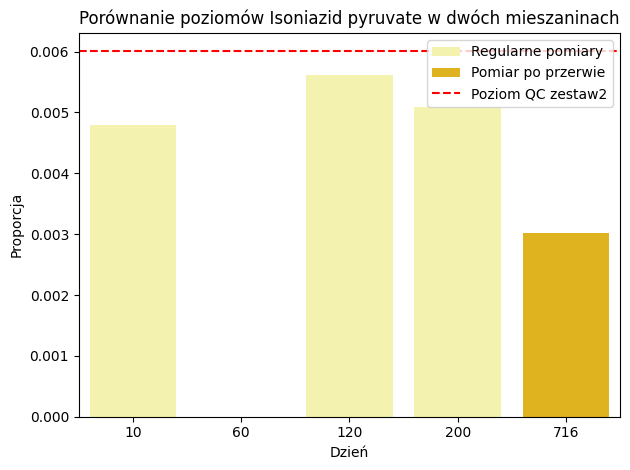

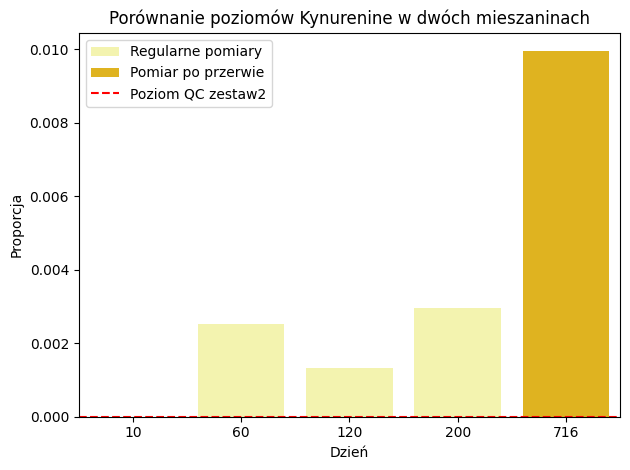

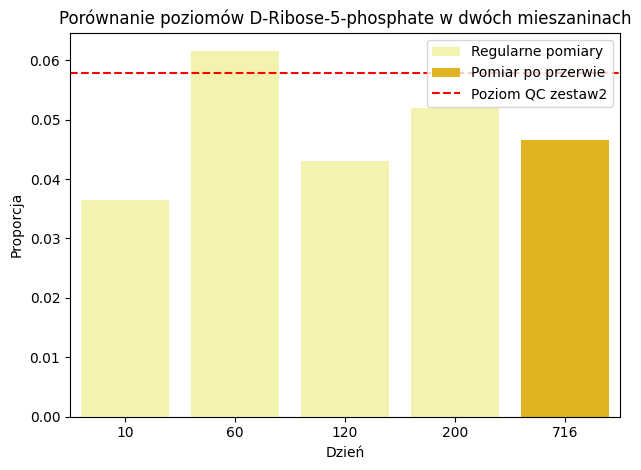

In [94]:
# solo

for s in solo:

        props_metab2s = props_metab2[s.label]


        QC2 = props_metab2s[-1]

        data = pd.DataFrame({
            'dzień': days2[:-1],
            'poziom': props_metab2s[:-1],
            'zestaw':['Zestaw 2']*len(days2[:-1]),
            'grupa': ['Regularne pomiary']*4 + ['Pomiar po przerwie']
        })
        paleta1 = sns.color_palette('pastel')
        paleta2 = sns.color_palette('bright')
        color1 = paleta1[8]
        color2 = paleta2[8]

        sns.barplot(data=data, x='dzień', y='poziom', hue='grupa', palette=[color1, color2])
        plt.axhline(y=QC2, color='red', linestyle='--', label='Poziom QC zestaw2')

        plt.title(f'Porównanie poziomów {s.label} w dwóch mieszaninach')
        plt.ylabel('Proporcja')
        plt.xlabel('Dzień')
        plt.tight_layout()
        plt.legend()
        plt.show()
